
This notebook delves into creating several columns (Filters 1-5). Filter 1-3 are contaminiation removal based on experimental negative controls, Salter et al genera, and fungi found in Narunsky-Haziza et al. Filter 4 is based on ML model of contamination using various inputs. Filter 5 involves filtering hits based on quality of alignments. 


# Explanation of the dataset
the input dataframe comes from an earlier notebook. The output dataframe is hits2 residing here: hits2.to_csv(mainDir10 + 'all_dons_cr_processed_5filters_postreview2022.csv', index=False)
Column explanations for hits2

- Blast dataframe columns (TS object is missing these columns):
    - **seqName**: e.g. A00111:327:HL57HDSXX:4:1202:22941:23719_TAGGTCAGAGACATCA_AGAAATAACGCC
    - **seq**: microbial sequence 
    - **refName**: the BLAST subject reference gi|1862738216|gb|CP055292.1| 
    - **pathogen**: common name of the hit "Shigella sonnei strain SE6-1 chromosome, complete genome"
    - **bitscore**: see BLAST tutorial
    - **pident**: percent identity between subject and query
    - **evalue**: see BLAST tutorial
    - **qstart**: query start position
    - **qend**: query end position
    -  **sstart**: subject start position
    -  **send**: subject end position
    -  **length**: length of the alignment between subject and query
    - Taxonomy columns 
        -  **tax_id**: taxonomic id with which we can get the following taxonomic categories
        -  **superkingdom**
        -  **phylum**
        -  **class**
        -  **order**
        -  **family**
        -  **genus**
        -  **species**
    -  **umi**: AGAAATAACGCC 
    -  **cell_bc_umi**: cell barcode and umi e.g. TGTCCCATGTACTCTG_CGTTGATACCAC
    -  **batch**: this is related to how blast was done for these donors (divided into batches with fixed number of input seqs)
    - **filepath**: where the output of the blast resides on my local drive


- TS object columns (blast dataframe does not produce these on its own)
    - **n_counts**: number of reads per cell
    - **n_genes**: number of genes per cell
    - **log2_n_counts**: log2 of n_counts
    - **log2_n_genes**: log2 of n_genes
    - **compartment**: e.g. immune, epithelial
    - **decision**: cell cycle decision
    - **celltype2**: cell type
    - **tissue_cell_type**: tissue and cell type
    - **cell_type_tissue**: cell type and tissue


- Shared columns:
    - **cell**: cell barcode+sample  TGGGCGTGTTGCGCAC_TSP14_Blood_NA_10X_1_1_1_5Prime
    - **cell_bc**: cell barcode with "-1" appended to it. (donor1and2, not for donors 3-16) e.g. CATATTCCAAAGCGGT-1
    - **tissue**: tissue type
    - **donor**: donor (e.g. TSP1)
    - **sample**: sample name e.g. TSP14_Bladder_NA_10X_1_2
    - **hit**: the column with which to seperate out the dataframe into blast (hit=='yes') and ts object (hit=='no')
    - **hit_type**: tells us whether the hit comes from an annotated cell (hit_type=='intra'), unannotated cell ('extra') or no hit ('none')
    - **donor_batch**: donor 1 and 2 dataframe ('1_2'), all others ('3_16')

- Cell ranger columns (rows with cr column=='yes should have all this info):
    - **cr**: "yes" if the sample was run through cell ranger pipeline, and "no" otherwise
    - **cr_sample**: the name of the cell ranger file
    - **n_counts_cr**: number of reads per droplet as determined by my cell ranger pipeline
    - **n_genes_cr**: same as above, for number of genes per droplet
    - **num_empty_drop_per_sample**: number of empty droplets in a sample (based on cut off of 200 genes)
    - **num_cell_drop_per_sample**: number of cell-containing droplets in a sample (based on cut off of 200 genes)
    


- Shared columns for removal of contaminants and poor alignments (all added in this notebook)
    - **'filter1'**: Removal of species and taxids found in the 10X experimental contamination dataset (1= contaminant, 0=non-contaminant)
    - **'filter2'**: Removal of genera found in the Salter et al. list of common contaminant genera (1=contaminant)
    - **'filter3'**: Removal of certain fungal species found in the Haziza et al dataset 
    - **'filter4'**: Removal of putative contaminants based on ML model prediction
    Filter4 is based on ML model prediction which takes into account the following columns. 
    - **'num_tissues'**: Number of tissues that each species appears in
    - **'num_donors'**: Number of donors that each species appears in
    - **'abundance'**: The total abundance of each species (number of hits) in the TS dataset
    - **'med_pident'**:  Median percent identity of alignments corresponding to a given species
    - **'med_length'**: Median alignment length corresponding to a given species
    - **'med_ngene'**: Median number of genes per droplet that contains a given species
    - **'pred'**: The prediction of the model. The input label of the model are species, 1 if any of the previous filters are 1 (contaminant), and 0 otherwise. 
    - **'R_g'**: R_g is c_g/ts_g. c_g is the number of species from genus g that have been detected in the experimental contamination dataset, and ts_g is the number of species from that genus detected in the total ts dataset. The ratio is a measure of confidence in a genus. If a genus has more species detected in the contamination dataset than in the total TS dataset, then even species that were not detetcted in the contamination dataset are less trustworthy considering that we show taxonomic assignment at the species level using short-read sequencing (~100bp) is not nearly as precise as genus level assignments 
    - **'filter5'** : We combine pident and length alignment parameters into one that measures the number of exact base matches in the alignment. This new pararmeter,"pidlen" =pident*length/100. pidlen > pthresh will be 0, and 1 otherwise. pthresh corresponds to 3sigma away from the mean of the second pidlen distribution. Essentially we select for high-quality alignments using this filter. 
    - **'pidlen'**: pident*length/100 corresponds to number of exact base matches in the alignment



### Loading libraries

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
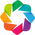

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib_venn import venn2, venn3
import venn
from venn import venn4
from venn import venn5
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 120
font_label_size=12
plt.rcParams['font.size'] = font_label_size
plt.rcParams['legend.fontsize'] = font_label_size
plt.rcParams['figure.titlesize'] = font_label_size
plt.rcParams['axes.labelsize']= font_label_size
plt.rcParams['axes.titlesize']= font_label_size
plt.rcParams['xtick.labelsize']= font_label_size
plt.rcParams['ytick.labelsize']= font_label_size
plt.rcParams["font.family"] = "arial"
import collections
from collections import Counter, ChainMap
import os
import glob
import re
import itertools
import math
import random
from random import randrange
import string
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from statistics import mean
from matplotlib import pyplot
import scipy.stats as st
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,cross_validate,RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix,auc,roc_auc_score,mean_absolute_error,mean_squared_error,precision_score,f1_score,classification_report,precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import mixture
import upsetplot
from upsetplot import UpSet, generate_counts, from_contents, plot
from pyvis.network import Network
import seaborn as sns
cmap = sns.cm.rocket_r
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot
from bokeh.sampledata.les_mis import data
import panel as pn
import panel.widgets as pnw
pn.extension()
import holoviews as hv
from holoviews import opts, dim
from holoviews.plotting.util import process_cmap
import plotly.graph_objects as go
import plotly.express as pex
hv.extension('bokeh')
hv.output(size=150)
import pickle5 as pickle



### Directories 

In [2]:
mainDir = '/oak/stanford/groups/quake/gita/raw/tab1_20200407/thirdAnalysis/10x/'
mainDir10 = '/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/all/'

paper = '/oak/stanford/groups/quake/gita/raw/nb/microbe/paper/forGitHub/human_tissue_microbiome_atlas/post_review/'
tables = paper + 'tables/'
images = paper + 'images/'
savedmodel = paper + 'model/'
external_datasets = paper + 'external_datasets/'
dbDir = '/oak/stanford/groups/quake/gita/raw/database/taxonomyNCBI20200125/'
taxDir = dbDir + 'taxonkit/'
tax = pd.read_csv(dbDir + 'ncbi_lineages_2021-01-26.csv')
tax_short=tax[['tax_id','superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']] #want to take only the following columns from the lineage dataframe tax 


/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (5,6,7,8,11,12,13,14,15,16,17,18,19,20,28,29,30,31,32,33,34,35,36,38,41,42,43,44,45,46,47,48,49,50,51,52,53,55,56,57,58,59,61,62,63,64,65,66,67,68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.



the main dataframe from earlier notebook cell_ranger_counts.ipynb

In [3]:
hits= pd.read_csv(mainDir10 + 'all_dons_cr_processed_postreview2022.csv')
print(hits.shape[0])
hits['compartment'] = hits['compartment'].str.lower()
hits = hits[(hits['tissue']!='eye') & (hits['superkingdom']!='Archaea')] #excluding the tissue eye (not sure about annotations), and the few Archaeal reads since we did not explicitly look for Archaea
print(hits.shape[0])
#let's exlcude any common synthetic vectors
hits = hits[~hits['species'].str.contains('phiX174|synthetic|cloning|vector', case=False, na=False)]
hits.shape[0]

/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (4,5,6,7,9,10,11,12,22,23,24,25,26,27,28,29,30,32,33,40) have mixed types.Specify dtype option on import or set low_memory=False.



2406150
2293592


2292301

let's also work with just the part of the dataframe that contains hits since we are concerned with contamination removal for now. At the end, we can put together the part that is just cells without hits "hits_no"

In [96]:
hits_yes = hits[hits['hit']=='yes']
hits_no = hits[hits['hit']=='no']
print(hits_yes.shape[0])
print(hits_no.shape[0])

1830306
461995


saving hits_no for concatenating it back with hits_yes once several filters have been added to it.  

In [188]:

hits_no.to_csv(mainDir10 + 'hits_no.csv', index=False)

### Filter 1: eliminating known contaminating species determined experimentally
will create a column "filter1" to flag these species 


In [97]:
# #this is a list of common contaminating genera primarily from  https://link.springer.com/article/10.1186/s12915-014-0087-z  
cont_genus = pd.read_csv(tables + 'contamination_genus_species.csv', delimiter='\t')
salter_cont_genus_lst = cont_genus['genus'].tolist()

#contamination hits 
contam= pd.read_csv(tables + 'negative_control_raw.csv')
contam = contam[contam['species']!=('uncultured bacterium')] #this species name is non-descriptive, so I will find these by their taxonomic id which is "1612"
contam_taxids = list(contam['staxids'].unique())

contam_sp = list(contam['species'].unique())
#on the other hand, there are few more search terms that need to be excluded more generally
contam_g = list(contam['genus'].unique())
#making sure that there are no nans in the list of contaminating genera or species
contam_g.remove(np.NaN)
contam_sp.remove(np.NaN)

In [98]:
hits_yes.loc[(hits_yes['species'].isin(contam_sp)==False) & (hits_yes['tax_id'].isin(contam_taxids)==False) ,'filter1']=0
hits_yes.loc[(hits_yes['species'].isin(contam_sp)) | (hits_yes['tax_id'].isin(contam_taxids)),'filter1']=1


/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



What fraction of reads remain?

In [99]:
np.round(hits_yes[(hits_yes['filter1']!=1)].shape[0]/hits_yes.shape[0],2)

0.1

### Filter 2: removing salter genera

In [100]:
hits_yes.loc[(hits_yes['genus'].isin(salter_cont_genus_lst)==False),'filter2']=0
hits_yes.loc[(hits_yes['genus'].isin(salter_cont_genus_lst)),'filter2']=1


what fraction of reads remain after both filter1 and filter2 are imposed?

In [101]:
np.round(hits_yes[(hits_yes['filter1']!=1) & (hits_yes['filter2']!=1)].shape[0]/hits_yes.shape[0],3)

0.074

### Calculating R_g (or contaminant species fraction) for each genus
R_g is c_g/ts_g. c_g is the number of species from genus g that have been detected in the contamination dataset, and ts_g is the number of species from that genus detected in the total ts dataset. 

The premise behind this parameter is that species are much harder to detect precisely with short reads than are genera, thus if several species from a genus are known contaminants, then it's harder to trust other species from that genus. Thus we can eliminate the genus to be sure. However, rather than imposing this directly, we can use this parameter in the ML model. 

Below I'm getting c_g "num_sp_contam" and ts_g "num_sp_hits". Then getting R_g for each genus in the "nums" dataframe

In [102]:
num_sp_hits=pd.DataFrame(pd.DataFrame(hits_yes.groupby(['genus', 'species']).size()).reset_index()[['genus', 'species']]['genus'].value_counts())
num_sp_contam=pd.DataFrame(pd.DataFrame(contam.groupby(['genus', 'species']).size()).reset_index()[['genus', 'species']]['genus'].value_counts())
num_sp_hits = num_sp_hits.reset_index().rename(columns={'genus':'ts', 'index':'genus'})
num_sp_contam = num_sp_contam.reset_index().rename(columns={'genus':'contam', 'index':'genus'})
nums = num_sp_hits.merge(num_sp_contam, on='genus', how='outer').fillna(0)

nums['R_g']=nums['contam']/nums['ts']
nums = nums.sort_values(by='R_g', ascending=False)
nums.head() 

,genus,ts,contam,R_g
2773,Chaetoceros,0.0,1.0,inf
2609,Poecilobdella,0.0,1.0,inf
2602,Candidatus Carsonella,0.0,1.0,inf
2603,Theropithecus,0.0,1.0,inf
2604,Peltonychia,0.0,1.0,inf


if a genus only appears in the contamination dataset and not in ts, then it gets R_g = inf. We can exclude those since they are not detected in the TS dataset. There are 266 genera in that category. 

In [103]:
nums = nums[nums['R_g']!=np.inf]


#### Now statistical test between Salter genera and all other other genera
what is the median R_g for Salter genera compared to those that are not in Salter. Is there a statistically different R_g value that would signal that this parameter is useful for decontamination? 
Indeed, R_g is statiscally greater for Salter genera than other genera found in our study. Mann-Whitney U test with "greater" alternative hypothesis, results in a Pvalue ~ 1e-23, thus we can say Salter genera have statistically greater R_g value than the rest of genera. 

There are 77 genera found in Salter that we have found in our contamination or TS dataset too. 

In [104]:
nums_sal = nums[nums['genus'].isin(salter_cont_genus_lst)]

In [105]:
nums_sal_not = nums[nums['genus'].isin(salter_cont_genus_lst)==False]

here is a difference in their median R_g value

In [106]:
print('salter genera median R_g value:', np.round(np.median(nums_sal['R_g']),2))
print('non salter genera median R_g value', np.median(nums_sal_not['R_g']))

salter genera median R_g value: 0.12
non salter genera median R_g value 0.0


In [107]:
# perform two-sided test. You can use 'greater' or 'less' for one-sided test
st.mannwhitneyu(x=nums_sal['R_g'], y=nums_sal_not['R_g'], alternative = 'greater')


MannwhitneyuResult(statistic=134952.5, pvalue=3.74561189232074e-23)

### adding R_g values for each genus 
note for the genera where the genus is np.nan (not many of them), the R_g value will also be np.nan

In [108]:
hits_yes = nums[['genus', 'R_g']].merge(hits_yes, on='genus', how='outer')

### Filter 3: eliminating certain fungal species based on a recent study

In addition to our own experimentally determined contaminants, we can leverage a recent study that has flagged putative contaminant fungal species in human tissue samples. The table is Table S3. In-depth contamination analysis for TCGA fungal calls, related to Figures 3, 5, and 6, and STAR Methods. \
https://www.cell.com/cell/fulltext/S0092-8674(22)01127-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867422011278%3Fshowall%3Dtrue#secsectitle00201


In [109]:
fung=pd.read_excel(external_datasets + 'fungal_dataset_knight.xlsx', delimiter='\t')
fung.columns = ['OGU','decontam_freq','decontam_prev','decontam_p_freq','decontam_predicted_contaminant','shared_with_WIS','in_hmp_gut_mycobiome_metagenomic_data','known_human_association_literature','species','comments_and_literature','decision','reason']
fung = fung.iloc[1:] #formatting to leave out the first descriptive line in the excel file & turn it into a dataframe i can easily work with
fung.head(1)

,OGU,decontam_freq,decontam_prev,decontam_p_freq,decontam_predicted_contaminant,shared_with_WIS,in_hmp_gut_mycobiome_metagenomic_data,known_human_association_literature,species,comments_and_literature,decision,reason
1,G000001985,0.000213569,1214,0.108752,False,NO,NO,YES,Talaromyces marneffei,PMID 29281582,KEEP,Known human association


In [110]:
suspected_contam_fung = fung[fung['decision']=='DISCARD']['species'].tolist() #based on the study, these are thought to have no human association
tru_fung = fung[fung['decision']=='KEEP']['species'].tolist() #thought to be part of the microbiome


In [111]:
hits_yes.loc[hits_yes['species'].isin(suspected_contam_fung),'filter3']=1
hits_yes.loc[hits_yes['species'].isin(tru_fung),'filter3']=0


What fraction of hits remain after all filters so far?

In [112]:
np.round(hits_yes[(hits_yes['filter1']!=1) & (hits_yes['filter2']!=1) & 
                 (hits_yes['filter3']!=1) ].shape[0]/hits_yes.shape[0],4)

0.0738

### Filter 4: eliminating certain species that the best ML model predicts as a contaminant 

building several ML models for detection of putative contaminants based on several features: 1) total abundance 2) number of donors that are positive for a given species,  3) number of tissues, 4) median number of genes of droplets in which the species was found, and 5) superkingdom (or domain) level classification, 6) Rg (see previous sections). 

We divide the dataset into two parts, part A and B. Part A will then be partitioned further for training, validation and testing models. Note, part A includes a hold out portion for testing. Part B, which is 75% of the data, already has labels (based on previous three filters), however using the best model captured from part A, we will get additional "putative" contaminants. Some of these will indeed be false positives but others may be species that were missed during sequencing, which the model may be able to detect based on learning common features of contaminant species.

part A: 
First, we use SMOTE oversampling technique to balance the training dataset as it is currently dominated by non-contaminating species. We test the performance of several types of ML models (e.g. random forest, knn, neural net) and select the best performing based on cross-validation and test scores. 

part B: 
using the best model type from part A, we predict labels for part B. We select only species that the model predicts are contaminants to add to the experimentally determined contaminants. 


for training and testing ML models, we need samples that have been run through cell ranger, because one feature that will be used in training is median n_genes which an out of cell ranger. We also need species that have known genera, because of R_g. Thus we create a "sub" dataframe that imposes those requirements. We will also apply all previous filters to build the model (i.e. those species flagged will be considered contaminants). if any of the previous filters are ==1 (i.e. putative or known contaminant) then we will assign a 
'training_label'==1. Otherwise, they get a lable ==0
Note, we are already working with the part of the dataframe that doesn't include cells without hits. 

In [113]:
hits_yes.shape[0]

1830306

In [114]:
sub=hits_yes[(hits_yes['cr']=='yes') & (hits_yes['genus'].isnull()==False)]

In [115]:
sub.shape[0]

1735955

training label ==1 (i.e. known or putative contaminant)

In [116]:
sub.loc[((sub['filter1']==1) | (sub['filter2']==1) | (sub['filter3']==1)) , 'training_label']=1

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



training label==0 (i.e likely true signal)

In [117]:
sub.loc[~((sub['filter1']==1) | (sub['filter2']==1) | (sub['filter3']==1)), 'training_label']=0

Note large fraction of labels are 1, or contamination. 

In [118]:
sub['training_label'].value_counts(dropna=False)

1.0    1656274
0.0      79681
Name: training_label, dtype: int64

In [119]:
sub.head(2)

,genus,R_g,tissue,donor,n_counts,n_genes,compartment,tissue_cell_type,cell_type_tissue,decision,...,cr_sample,n_counts_cr,n_genes_cr,cr,num_empty_drop_per_sample,num_cell_drop_per_sample,filter1,filter2,filter3,training_label
0,Niastella,2.0,thymus,TSP2,NaN,NaN,NaN,NaN,NaN,NaN,...,TSP2_Thymus_NA_10X_1_4_5prime_S33,59.0,47.0,yes,603041.0,1352.0,1.0,1.0,NaN,1.0
1,Niastella,2.0,thymus,TSP2,NaN,NaN,NaN,NaN,NaN,NaN,...,TSP2_Thymus_NA_10X_1_4_5prime_S33,59.0,47.0,yes,603041.0,1352.0,1.0,1.0,NaN,1.0


now building the model based on hits from samples that went through cell ranger pipeline

In [120]:
df = sub
labellist=[] #training labels (1 or 0)
numtissuelist=[] #number of tissues the species was found
taxidlist=[] 
abundancelist =[] #the total abundance of a species in the TS dataset
donlist=[] #number of donors 
ngenelist=[] #number of genes per droplet in which a species was found
tissuelist=[] #the tissues in which the species appears ini
splist=[] 
pidlist=[] #median percent identity 
llist=[] #median alignment length list for that species
rglist =[] #the R_g of the genus to which the species belongs

for sp in list(df.species.unique()):
    sp_df = df[df['species']==sp]
    count = sp_df.shape[0]
    labellist.append(list(sp_df['training_label'].unique())[0])
    num_tis = sp_df['tissue'].nunique()
    numtissuelist.append(num_tis)
    tis = sp_df['tissue'].unique()
    tissuelist.append(tis)    
    num_dons = sp_df['donor'].nunique()
    donlist.append(num_dons)
    taxidlist.append(sp_df['tax_id'].iloc[0])
    abundancelist.append(count)
    ngenelist.append(np.mean(sp_df['n_genes_cr']))
    pidlist.append(np.median(sp_df['pident']))
    llist.append(np.median(sp_df['length']))
    rglist.append(sp_df['R_g'].iloc[0])
        
total=pd.DataFrame({'training_label': labellist, 'num_tissues': numtissuelist, 'num_donors':donlist , 
                      'taxid': taxidlist,  'abundance': abundancelist, 'med_pident':pidlist,
                     'med_length': llist, 'med_ngene':ngenelist, 
                     'tissues':tissuelist, 'R_g': rglist})    


In [121]:
#lets shuffle the dataframe so that the model isn't biased
total = shuffle(total, random_state=1)
total = total.rename(columns={'taxid':'tax_id'})
total['tax_id'] = total['tax_id'].astype(int).astype(str)
tax_short['tax_id'] = tax_short['tax_id'].astype('str')
total=total.merge(tax_short, on='tax_id', how='left')

/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [123]:
total['training_label'].value_counts(dropna=False)

0.0    5311
1.0    1983
Name: training_label, dtype: int64

#### Saving model input dataframe

In [124]:
total.to_csv(mainDir10 + 'true_and_contam_species_input_to_model.csv', index=False)

now picking from the total (containing species from both contamination and true signal) a list of columns to build a model with. 

In [125]:
total=pd.read_csv(mainDir10 + 'true_and_contam_species_input_to_model.csv')

In [126]:
total.columns

Index(['training_label', 'num_tissues', 'num_donors', 'tax_id', 'abundance',
       'med_pident', 'med_length', 'med_ngene', 'tissues', 'R_g',
       'superkingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'species'],
      dtype='object')

In [127]:
tot = total[['num_tissues', 'num_donors','abundance', 'med_pident',
       'med_length', 'med_ngene',"R_g", 'superkingdom', 'training_label']]

#### This is where we obtain the dataframe containing species (rows) and various features collected on those species (columns)
We will also split the dataframe into part A (X,y) and part B (Xprime, yprime)

4466

In [131]:
total2 = pd.get_dummies(tot, columns=['superkingdom']) #one hot encoding of phylum information
total2x= total2.drop(['training_label'], axis=1) #this is our y (what we want to predict, whether the species is contaminant or not)
total2y= total2['training_label']

#first I want to divide the data into 75% untouched (Xprime, yprime), 25% for training, validation  & testing (X, y)
X, Xprime, y, yprime = train_test_split(total2x, total2y, test_size=0.75, random_state=1)

print('for training, cross validation, and testing:', X.shape, y.shape)
print('untouched portion of data:', Xprime.shape, yprime.shape)


for training, cross validation, and testing: (1823, 10) (1823,)
untouched portion of data: (5471, 10) (5471,)


In [133]:
X.head(3)

,num_tissues,num_donors,abundance,med_pident,med_length,med_ngene,R_g,superkingdom_Bacteria,superkingdom_Eukaryota,superkingdom_Viruses
3322,1,1,1,100.0,62.0,74.000000,0.000000,1,0,0
3966,3,2,4,100.0,79.5,59.500000,0.000000,0,1,0
809,9,4,4112,100.0,90.0,64.812014,0.133333,1,0,0


#### Building the models

In [134]:
replicates=10
all_rep_test_results= pd.DataFrame({})
all_rep_p=pd.DataFrame({})
all_rep_r=pd.DataFrame({})
all_rep_f1=pd.DataFrame({})
all_rep_roc=pd.DataFrame({})

#where i will store precision, recall, f1, and auroc values from xvalidation
allp=pd.DataFrame({})
allr=pd.DataFrame({})
allf1=pd.DataFrame({})
allroc=pd.DataFrame({})

#this is for cross validation (k value)
numsplit=10 

model_names = ['gradient boosting classifier', 'logistic regression', 
               'random forest','knn', 
               'support vector rbf', 'multi-layer perceptron']


for i in range(replicates):
    #splitting the dataset into train and test
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=i)
    #scaling the train and test data
    scale = StandardScaler().fit(x_train)
    x_train_std = scale.transform(x_train)
    x_test_std = scale.transform(x_test)

    #applying smote oversampling of the minority class only during training
    sm = SMOTE(random_state=0)
    xt,yt = sm.fit_resample(x_train_std,y_train)

    #fitting several models
    gbc = GradientBoostingClassifier(random_state=0).fit(xt,yt)
    lr = LogisticRegression(random_state=0).fit(xt,yt)
    tree = DecisionTreeClassifier(random_state=0).fit(xt,yt)
    rf = RandomForestClassifier(random_state=0).fit(xt,yt)
    knn = KNeighborsClassifier().fit(xt,yt)
    sv_lin = SVC(kernel='linear',random_state=0,probability=True).fit(xt,yt)
    sv_rbf = SVC(kernel='rbf',random_state=0,probability=True).fit(xt,yt)
    mlp = MLPClassifier(random_state=1, max_iter=300).fit(xt, yt)

    #this is going to hold test data
    test_results=pd.DataFrame(columns=['auroc','aupr'])
    auprlist=[]
    auroclist =[]
    f1list=[]
    modelnameslist=[]

    for ind,model in enumerate([gbc, lr, rf,knn, sv_rbf, mlp]):

        #Create Stratified K-fold cross validation
        cv = StratifiedKFold(n_splits=numsplit, random_state=1, shuffle=True)

        #Evaluate the models during cross validation based on roc_auc scores
        crossval_prec = pd.DataFrame(cross_val_score(model,xt,yt,scoring='precision',cv=cv))
        crossval_recall = pd.DataFrame(cross_val_score(model,xt,yt,scoring='recall',cv=cv))
        crossval_f1 = pd.DataFrame(cross_val_score(model,xt,yt,scoring='f1',cv=cv))
        crossval_auroc = pd.DataFrame(cross_val_score(model,xt,yt,scoring='roc_auc',cv=cv))

        #these are the cross validation metric results
        crossval_prec['model']=model_names[ind]
        crossval_prec['metric']=['precision']*crossval_prec.shape[0]
        crossval_prec['replicate']=[i]*crossval_prec.shape[0]
        allp = pd.concat([allp, crossval_prec])

        crossval_recall['model']=model_names[ind]
        crossval_recall['metric']=['recall']*crossval_recall.shape[0]
        crossval_recall['replicate']=[i]*crossval_recall.shape[0]
        allr = pd.concat([allr, crossval_recall])
        
        crossval_f1['model']=model_names[ind]
        crossval_f1['metric']=['f1']*crossval_f1.shape[0]
        crossval_f1['replicate']=[i]*crossval_f1.shape[0]
        allf1 = pd.concat([allf1, crossval_f1])

        crossval_auroc['model']=model_names[ind]
        crossval_auroc['metric']=['auroc']*crossval_auroc.shape[0]
        crossval_auroc['replicate']=[i]*crossval_auroc.shape[0]
        allroc = pd.concat([allroc, crossval_auroc])

        #make predictions on test data
        pred = model.predict(x_test_std)

        #get precision and recall
        precision,recall, _ = precision_recall_curve(y_test,pred)
        aupr = round(auc(recall,precision),2)
        auroc = round(roc_auc_score(y_test,pred),2)
        auprlist.append(aupr)
        auroclist.append(auroc)
        f1 = round(f1_score(y_test,pred),2)
        f1list.append(f1)
        modelnameslist.append(model_names[ind])
        
        

    #this is the test result (withheld portion of data)
    test_results['aupr']=auprlist
    test_results['auroc']=auroclist
    test_results['f1']=f1list
    test_results['model']=modelnameslist
    test_results['replicate']=i

    #these are the dataframes that summarize results for all replicates
    all_rep_test_results=pd.concat([all_rep_test_results, test_results])

allp=allp.rename(columns={0:'vals'})
allr=allr.rename(columns={0:'vals'})
allf1=allf1.rename(columns={0:'vals'})
allroc=allroc.rename(columns={0:'vals'})

#saving all the models
gbc = GradientBoostingClassifier(random_state=0).fit(xt,yt)
lr = LogisticRegression(random_state=0).fit(xt,yt)
tree = DecisionTreeClassifier(random_state=0).fit(xt,yt)
rf = RandomForestClassifier(random_state=0).fit(xt,yt)
knn = KNeighborsClassifier().fit(xt,yt)
sv_lin = SVC(kernel='linear',random_state=0,probability=True).fit(xt,yt)
sv_rbf = SVC(kernel='rbf',random_state=0,probability=True).fit(xt,yt)
mlp = MLPClassifier(random_state=1, max_iter=300).fit(xt, yt)

# save the best model (in this case gbc model) to disk
pickle.dump(gbc, open(savedmodel + '/gbc_2.sav', 'wb'))




/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/home/groups/quake/gita/miniconda3/envs/mainEnv2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged ye

in addition to saving the best model, I want to save the test results, so I don't have to rerun the model for plotting everytime

In [135]:
all_rep_test_results.to_csv(savedmodel + '/all_rep_test_results_2.csv', index=False)
allp.to_csv(savedmodel + '/allp_2.csv', index=False)
allr.to_csv(savedmodel + '/allr_2.csv', index=False)
allf1.to_csv(savedmodel + '/allf1_2.csv', index=False)
allroc.to_csv(savedmodel + '/allroc_2.csv', index=False)


In [136]:
all_rep_test_results= pd.read_csv(savedmodel + '/all_rep_test_results_2.csv')
allp= pd.read_csv(savedmodel + '/allp_2.csv')
allr= pd.read_csv(savedmodel + '/allr_2.csv')
allf1= pd.read_csv(savedmodel + '/allf1_2.csv')
allroc= pd.read_csv(savedmodel + '/allroc_2.csv')


#### Let's take a look at cross validation metrics AUROC, AUPR
also the box plots represent data from 10 fold cross validation, and 10 seperate splits (e.g. 100 folds)

In [137]:
model_names = ['gradient boosting classifier', 'logistic regression', 
               'random forest','knn',
               'support vector rbf', 'multi-layer perceptron']

#starting a summary dataframe for the metric of interest.
colnames = ['auroc_xval_95perc_ci_lower', 'auroc_xval_95perc_ci_upper']
sum_df = pd.DataFrame(index=model_names, columns=colnames)
metric_type = allroc

for mname in model_names:    
    data = metric_type[metric_type['model']==mname]['vals']
    lb = np.round(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))[0],3)
    ub = np.round(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))[1],3)
    sum_df.loc[mname,colnames[0]]=lb
    sum_df.loc[mname,colnames[1]]=ub  
sum_df.sort_values(by=colnames[0], ascending=False)

,auroc_xval_95perc_ci_lower,auroc_xval_95perc_ci_upper
random forest,0.945,0.952
gradient boosting classifier,0.937,0.944
multi-layer perceptron,0.897,0.906
knn,0.896,0.904
support vector rbf,0.811,0.823
logistic regression,0.805,0.817


Text(0.5, 1.0, 'auroc')

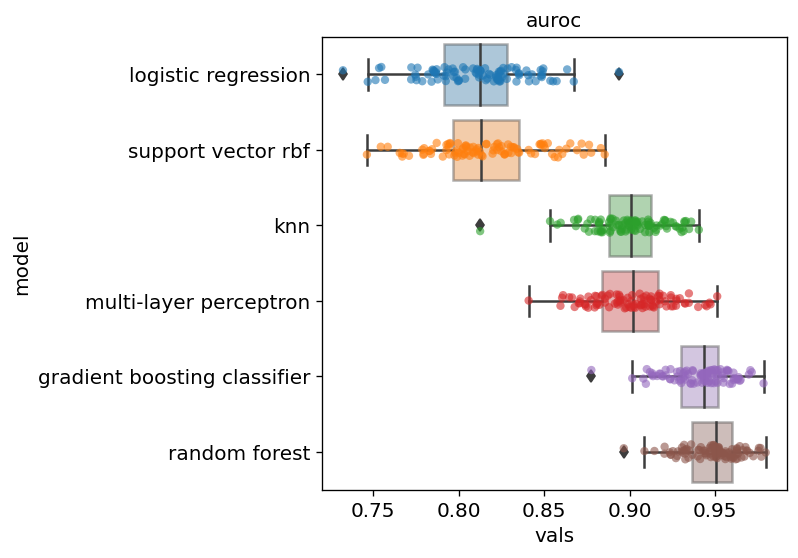

In [138]:
from matplotlib.legend_handler import HandlerTuple

allroc['median'] = allroc.groupby('model')['vals'].transform('median')
allroc = allroc.sort_values(by='median')

ax = sns.boxplot(data=allroc, x='vals', y="model", boxprops={'alpha': 0.4})
sns.stripplot(data=allroc, x='vals', y="model", dodge=True, ax=ax, alpha= 0.6)
plt.title('auroc')

Text(0.5, 1.0, 'F1 score')

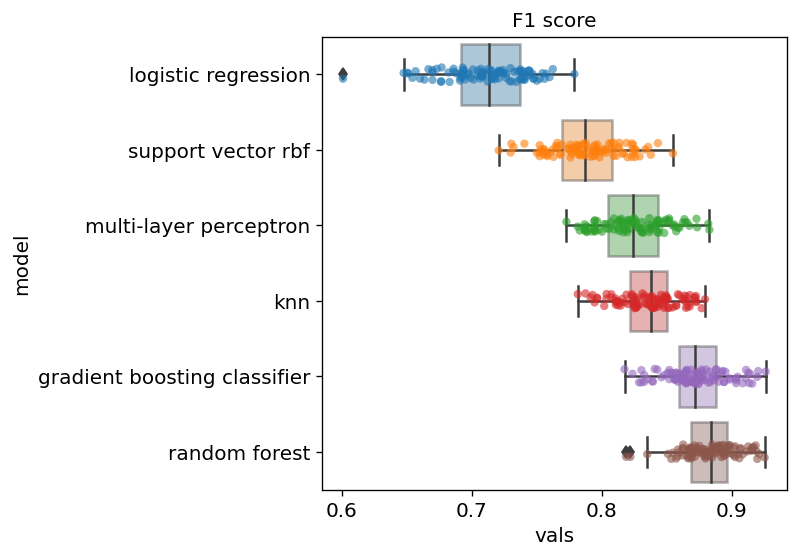

In [139]:
allf1['median'] = allf1.groupby('model')['vals'].transform('median')
allf1 = allf1.sort_values(by='median')
ax = sns.boxplot(data=allf1, x='vals', y="model", boxprops={'alpha': 0.4})
sns.stripplot(data=allf1, x='vals', y="model", dodge=True, ax=ax, alpha=.6)
plt.title('F1 score')

#### Let's take a look at test metrics AUROC, AUPR against the held out dataset
10 splits iterartions

#### AUROC on heldout test dataset

In [140]:
#starting a summary dataframe for the metric of interest.
colnames = ['auroc_test_95perc_ci_lower', 'auroc_test_95perc_ci_upper']
sum_df = pd.DataFrame(index=model_names, columns=colnames)
metric_type = all_rep_test_results[['auroc','model']]

for mname in model_names:    
    data = metric_type[metric_type['model']==mname]['auroc']
    lb = np.round(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))[0],3)
    ub = np.round(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))[1],3)
    sum_df.loc[mname,colnames[0]]=lb
    sum_df.loc[mname,colnames[1]]=ub
sum_df.sort_values(by=colnames[0], ascending=False)

,auroc_test_95perc_ci_lower,auroc_test_95perc_ci_upper
gradient boosting classifier,0.82,0.836
random forest,0.785,0.807
multi-layer perceptron,0.765,0.797
support vector rbf,0.733,0.767
knn,0.71,0.758
logistic regression,0.703,0.727


#### AUPR on heldout test dataset

In [141]:
#starting a summary dataframe for the metric of interest.
colnames = ['aupr_test_95perc_ci_lower', 'aupr_test_95perc_ci_upper']
sum_df = pd.DataFrame(index=model_names, columns=colnames)
metric_type = all_rep_test_results[['aupr','model']]

for mname in model_names:    
    data = metric_type[metric_type['model']==mname]['aupr']
    lb = np.round(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))[0],3)
    ub = np.round(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))[1],3)
    sum_df.loc[mname,colnames[0]]=lb
    sum_df.loc[mname,colnames[1]]=ub
sum_df.sort_values(by=colnames[0], ascending=False)

,aupr_test_95perc_ci_lower,aupr_test_95perc_ci_upper
gradient boosting classifier,0.748,0.776
random forest,0.715,0.753
multi-layer perceptron,0.69,0.736
support vector rbf,0.668,0.702
knn,0.636,0.69
logistic regression,0.63,0.66


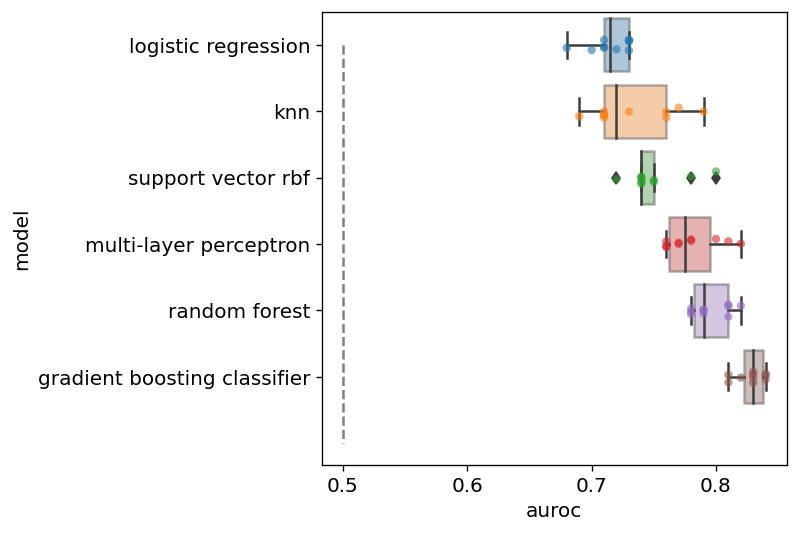

In [142]:
all_rep_test_results['median'] = all_rep_test_results.groupby('model')['auroc'].transform('median')
all_rep_test_results = all_rep_test_results.sort_values(by='median')


ax = sns.boxplot(data=all_rep_test_results, x='auroc', y="model", boxprops={'alpha': 0.4})
sns.stripplot(data=all_rep_test_results, x='auroc', y="model", dodge=True, ax=ax, alpha=.6)

#the null value is 0.5 for auroc
ax.vlines(x = 0.5, ymin = 0, ymax=6,
           colors = 'grey', ls='--')

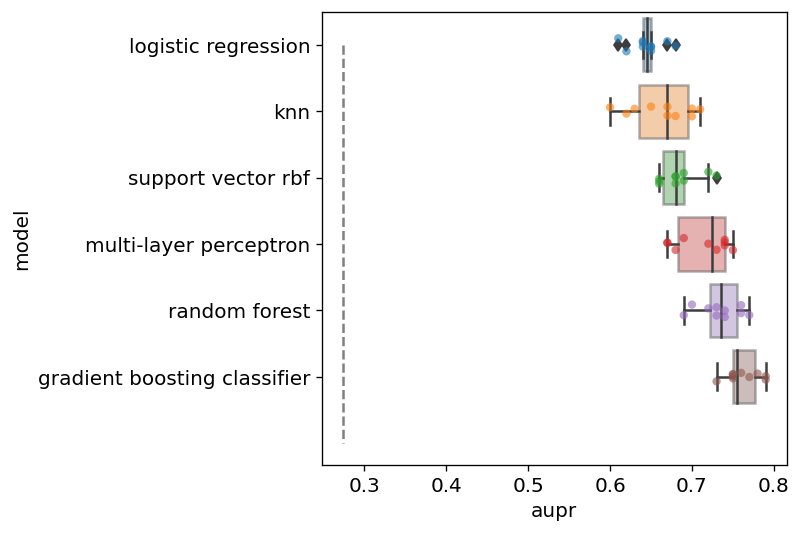

In [143]:
all_rep_test_results['median_aupr'] = all_rep_test_results.groupby('model')['aupr'].transform('median')
all_rep_test_results = all_rep_test_results.sort_values(by='median_aupr')

ax = sns.boxplot(data=all_rep_test_results, x='aupr', y="model", boxprops={'alpha': 0.4})
sns.stripplot(data=all_rep_test_results, x='aupr', y="model", dodge=True, ax=ax, alpha=.6)

#the null value is based on the prevelance of the positive class (if you don't want to rerun the model, uncomment below to get the fraction of the positive class in the test data)
ax.vlines(x = y_test.value_counts(normalize=True)[1], ymin = 0, ymax=6,
           colors = 'grey', ls='--')

#### let's load the model back on

In [144]:
model = pickle.load(open(savedmodel + '/gbc.sav', 'rb'))


#### now applying the model onto part B of the species dataset (75% of total dataset which has not been seen yet)
We will make some predictions about which species are putative contaminants

In [145]:
scale = StandardScaler().fit(Xprime)
Xprime_std = scale.transform(Xprime)
pred2 = model.predict(Xprime_std)
#this is part B dataframe that will contain some model predictions. Some of these will be false positives. 
partb = pd.concat([Xprime, pd.DataFrame(yprime)], axis=1)
partb['pred']=pred2
partb.head(1)

,num_tissues,num_donors,abundance,med_pident,med_length,med_ngene,R_g,superkingdom_Bacteria,superkingdom_Eukaryota,superkingdom_Viruses,training_label,pred
2857,1,2,2,97.6135,42.0,4.5,0.0,1,0,0,0.0,0.0


getting the species info for part B so I can exclude species that the model flags as contaminant

In [146]:
list_of_ind = partb.index.to_list()
#getting the relevant indices of total dataframe so i can see which species are there in the fin dataframe (fin)
partb_species=total[total.index.isin(list_of_ind)][['tax_id','superkingdom','phylum','class','genus','species']]

partb_withsp = pd.concat([partb, partb_species], axis=1)

#### What fraction of model predictions match labels that we know experimentally? 
~71% matched experimentally determined labels on unseen data. 

In [56]:
print('fraction of matching labels:', partb_withsp[partb_withsp['training_label'] ==partb_withsp['pred']].shape[0]/partb_withsp.shape[0])

fraction of matching labels: 0.7121184426978614


#### saving the dataframe containing model predictions for part b. 

In [147]:
partb_withsp.to_csv(tables + 'partb_withsp.csv', index=False)


In [148]:
partb_withsp=pd.read_csv(tables + 'partb_withsp.csv')

In [149]:
partb_withsp.head(3)

,num_tissues,num_donors,abundance,med_pident,med_length,med_ngene,R_g,superkingdom_Bacteria,superkingdom_Eukaryota,superkingdom_Viruses,training_label,pred,tax_id,superkingdom,phylum,class,genus,species
0,7,5,76,100.000,98.0,54.539474,0.200000,1,0,0,0.0,1.0,888055,Bacteria,Fusobacteria,Fusobacteriia,Leptotrichia,Leptotrichia wadei
1,1,2,5,100.000,89.0,82.400000,0.512821,1,0,0,1.0,1.0,2716879,Bacteria,Proteobacteria,Gammaproteobacteria,Citrobacter,Citrobacter sp. Y3
2,1,1,4,98.901,91.0,34.500000,0.133333,1,0,0,1.0,1.0,1325095,Bacteria,Proteobacteria,Alphaproteobacteria,Bradyrhizobium,Bradyrhizobium guangzhouense


#### Now merging model predictions with the rest of the original dataframe.  

In [59]:
hits_yes.shape[0]

1830306

In [150]:
partb_withsp_sub = partb_withsp[['num_tissues', 'num_donors', 'abundance', 'med_pident',
       'med_length', 'med_ngene','pred', 'species']]

In [151]:
hits_yes = hits_yes.merge(partb_withsp_sub, on='species', how='outer')
hits_yes.shape

(1830306, 58)

In [152]:
hits_yes.columns

Index(['genus', 'R_g', 'tissue', 'donor', 'n_counts', 'n_genes', 'compartment',
       'tissue_cell_type', 'cell_type_tissue', 'decision', 'cell', 'celltype2',
       'seqName', 'refName', 'pathogen', 'bitscore', 'pident', 'evalue',
       'qstart', 'qend', 'sstart', 'send', 'length', 'tax_id', 'batch',
       'filepath', 'superkingdom', 'phylum', 'class', 'order', 'family',
       'species', 'cell_bc', 'umi', 'cell_bc_umi', 'hit', 'hit_type',
       'log2_n_counts', 'log2_n_genes', 'sample', 'donor_batch', 'seq',
       'cr_sample', 'n_counts_cr', 'n_genes_cr', 'cr',
       'num_empty_drop_per_sample', 'num_cell_drop_per_sample', 'filter1',
       'filter2', 'filter3', 'num_tissues', 'num_donors', 'abundance',
       'med_pident', 'med_length', 'med_ngene', 'pred'],
      dtype='object')

#### putative contaminants based on model prediction (column "pred" == 1 is putative contaminant)

In [153]:
hits_yes.loc[hits_yes['pred']==1, 'filter4']=1
hits_yes.loc[hits_yes['pred']==0, 'filter4']=0

In [159]:
hits_yes.pred.value_counts(dropna=False)

1.0    1163787
NaN     627382
0.0      39137
Name: pred, dtype: int64

In [154]:
hits_yes.head(3)

,genus,R_g,tissue,donor,n_counts,n_genes,compartment,tissue_cell_type,cell_type_tissue,decision,...,filter2,filter3,num_tissues,num_donors,abundance,med_pident,med_length,med_ngene,pred,filter4
0,Niastella,2.0,thymus,TSP2,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Niastella,2.0,thymus,TSP2,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Niastella,2.0,thymus,TSP2,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What fraction of reads remain after all five filters are applied

In [156]:
print(np.round(hits_yes[(hits_yes['filter1']!=1) & (hits_yes['filter2']!=1) &
                 (hits_yes['filter3']!=1) & (hits_yes['filter4']!=1) ].shape[0]/hits_yes.shape[0],3))

0.058


In [160]:
hits.shape

(2292301, 47)

### Filter 5 : percent identity and length of alignments filter
We combine these two parameters into one that measures the number of exact base matches in the alignment. This new pararmeter, p or "pidlen" =pident*length/100

To figure out what threshold to use for p, we plot its histogram and notice a bimodal distribution. I then use Gaussian Mixture Model (GMM) to decompose this bimodal distribution into two gaussians. Then using the GMM's estimated mean and covariance for the second distribution, I arrive at a lowerbound threshold for p. Namely mean_2 - 3*sigma_2, where mean_2, and sigma_2 are the mean and standard deviation of the second gaussian. 

The premise behind using data from the second peak is that the first peak represents weaker alignments as well demonstrated by the appearance of viruses such as HIV and influenza in donors who were not sero positive for these viruses. 

We will assign alignments that belong to the second gaussian to 2, and the rest to 1 under the column "pidlen_dist".

Filter 5 is created based on the ratio of second distribution to first distribution number of hits for each species. 1=hits to eliminate, 0=hits to keep

code for GMM modified from: https://github.com/bnsreenu/python_for_microscopists/blob/master/52b-Understanding-GMM.py

In [161]:
hits_yes['pidlen']=hits_yes['pident']* hits_yes['length']/100

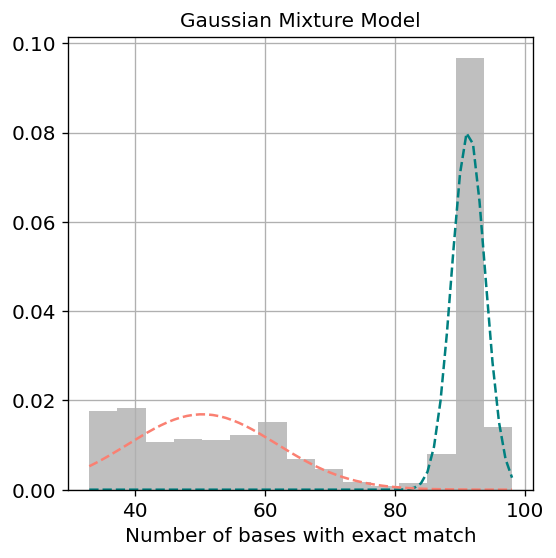

mean of the second distribution: 91.0
standard deviation of the second distribution: 3.0
lower bound threshold for pidlen, or pthresh: 82.0


In [162]:
import scipy.stats as stats

x=np.array(hits_yes['pidlen'])

f=x.reshape(-1,1)

# decompose into 2 Gaussians. 
g = mixture.GaussianMixture(n_components=2,covariance_type='full')
g.fit(f)
weights = g.weights_
means = g.means_
covars = g.covariances_

x_axis = x
x_axis.sort()

plt.hist(f, bins=15, histtype='bar', density=True, alpha=0.5, color='grey')
plt.plot(x_axis,weights[0]*stats.norm.pdf(x_axis,means[0],np.sqrt(covars[0])).ravel(), c='teal', ls='--')
plt.plot(x_axis,weights[1]*stats.norm.pdf(x_axis,means[1],np.sqrt(covars[1])).ravel(), c='salmon', ls='--')

plt.xlabel('Number of bases with exact match')
plt.title('Gaussian Mixture Model')

plt.grid()
plt.show()

#let's print some metrics and lb threshold for pidlen for the second distribution.  
for i in [0]: 
    if means[i][0]> means[i+1][0]:
        ind = i
    else:
        ind = i+1
        
mean_2 = np.round(means[ind][0]) 
sigma_2 = np.round(np.sqrt(covars[ind][0][0]))
pthresh = np.round(mean_2 - (3* sigma_2))
print('mean of the second distribution:', mean_2)
print('standard deviation of the second distribution:', sigma_2)
print('lower bound threshold for pidlen, or pthresh:', pthresh)

Assigning filter5 based on pidlen using the pthresh to make the cut off. 

In [163]:
hits_yes.loc[hits_yes['pidlen']>=pthresh, 'pidlen_dist']=2 #second distribution
hits_yes.loc[hits_yes['pidlen']<pthresh, 'pidlen_dist']=1 #first distribution

If we look at filtered data (filters 1-4), we arrive at the same pthresh. Note prior filters are disproportionately eliminating poor alignments 

In [164]:
hits_fil = hits_yes[(hits_yes['filter1']!=1) & (hits_yes['filter2']!=1) &
                 (hits_yes['filter3']!=1) & (hits_yes['filter4']!=1)]

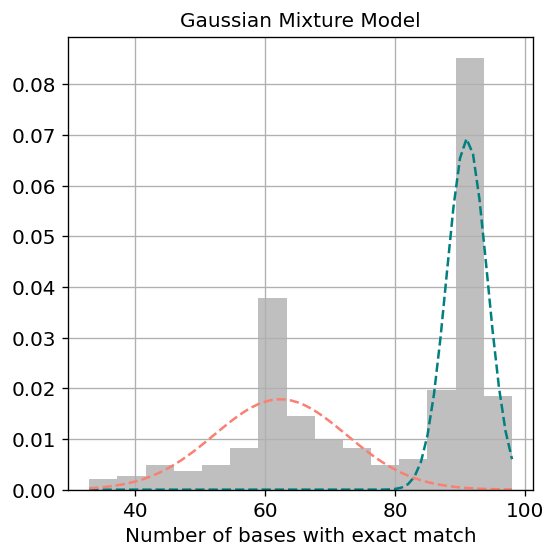

mean of the second distribution: 91.0
standard deviation of the second distribution: 3.0
lower bound threshold for pidlen, or pthresh: 82.0


In [165]:
x=np.array(hits_fil['pidlen'])

f=x.reshape(-1,1)

# decompose into 2 Gaussians. 
g = mixture.GaussianMixture(n_components=2,covariance_type='full')
g.fit(f)
weights = g.weights_
means = g.means_
covars = g.covariances_


plt.hist(f, bins=15, histtype='bar', density=True, alpha=0.5, color='grey')
plt.plot(x_axis,weights[0]*stats.norm.pdf(x_axis,means[0],np.sqrt(covars[0])).ravel(), c='teal', ls='--')
plt.plot(x_axis,weights[1]*stats.norm.pdf(x_axis,means[1],np.sqrt(covars[1])).ravel(), c='salmon', ls='--')

plt.xlabel('Number of bases with exact match')
plt.title('Gaussian Mixture Model')

plt.grid()
plt.show()

#let's print some metrics and lb threshold for pidlen for the second distribution.  
for i in [0]: 
    if means[i][0]> means[i+1][0]:
        ind = i
    else:
        ind = i+1
        
mean_2 = np.round(means[ind][0]) 
sigma_2 = np.round(np.sqrt(covars[ind][0][0]))
pthresh = np.round(mean_2 - (3* sigma_2))
print('mean of the second distribution:', mean_2)
print('standard deviation of the second distribution:', sigma_2)
print('lower bound threshold for pidlen, or pthresh:', pthresh)


note that we get rid of a lot of spurious hits by applying the pthresh on pidlen. Let's take a look at viruses 

In [166]:
vir = hits_fil[hits_fil['superkingdom']=='Viruses']
bac = hits_fil[hits_fil['superkingdom']=='Bacteria']
euk = hits_fil[hits_fil['superkingdom']=='Eukaryota']


These are viruses that were filtered by this filter

In [167]:
set(vir[vir['pidlen']<pthresh].species) - set(vir[vir['pidlen']>=pthresh].species) 


{'Adeno-associated virus',
 'American bat vesiculovirus',
 'Bacteriophage sp.',
 'Bluetongue virus',
 'Bovine alphaherpesvirus 1',
 'Bunyamwera orthobunyavirus',
 'Cafeteria roenbergensis virus',
 'Citrobacter phage IME-CF2',
 'Clostridium phage phiCT453A',
 'Columbid alphaherpesvirus 1',
 'Common moorhen coronavirus HKU21',
 'Cronobacter phage vB_CsaM_GAP161',
 'Diabrotica undecimpunctata virus 1',
 'Echinochloa crusgalli partitivirus',
 'Eptesipox virus',
 'Erwinia phage phiEt88',
 'Escherichia phage CMSTMSU',
 'Escherichia phage EMCL318',
 'Escherichia phage ESSI2_ev129',
 'Escherichia phage Lilleven',
 'Escherichia phage vB_EcoP_3HA13',
 'Escherichia virus 4MG',
 'Escherichia virus G4',
 'Escherichia virus MS2',
 'Escherichia virus P2_2H1',
 'Escherichia virus T7',
 'Escherichia virus Talmos',
 'Fowl aviadenovirus E',
 'Gallid alphaherpesvirus 1',
 'Genomoviridae sp.',
 'Human orthopneumovirus',
 'Influenza A virus',
 'Influenza B virus',
 'Kammavanpettai virus',
 'Luna mammarenavi

You can see for example that Influenza viruses A and B appear in all donors...Obviously erroneous. 

In [168]:
sp =vir[vir.species.str.contains('influenza', case=False)]

pd.DataFrame(sp.groupby(['species','donor']).size()).head(50)

0
species           donor      
Influenza A virus TSP10    46
                  TSP11     1
                  TSP12     1
                  TSP14  1321
                  TSP2    122
                  TSP4      1
                  TSP6     11
                  TSP7      2
Influenza B virus TSP10     1
                  TSP14     3

#### Interestingly, the number of hits per species (i.e. abundance) for those species belonging to second distribution (>pthresh) is significantly greater

This indicates further that hits with lower quality alignments are more likely spurious hits

In [169]:
cols=['filter1', 'filter2', 'filter3', 'filter4']
# this will select rows that have at least 1 column=1, across cols which are filter columns, hits_yes[hits_yes[cols].any(axis=1)]
one=hits_yes[(hits_yes[cols].any(axis=1)==False) & (hits_yes['pidlen_dist']==1)] #first distribution
two=hits_yes[(hits_yes[cols].any(axis=1)==False) & (hits_yes['pidlen_dist']==2)] #second distribution

In [170]:
st.mannwhitneyu(x=two.groupby(['species']).size(), y=one.groupby(['species']).size(), alternative = 'greater')


MannwhitneyuResult(statistic=4498515.0, pvalue=1.0969215388653559e-13)

#### Filter 5 to account for the fact that species can have hits from both distributions
Rather than simply filtering out any hits that appear in the first n_match distribution, what I will do is calculate the ratio of hits/species in distributions 1 and 2. If there are more hits for a given species in the second distribution, then I will keep the species.  


In [172]:
v1 = hits_yes[(hits_yes['pidlen_dist']==1) ] #hits that are in the first distribution
v2 = hits_yes[(hits_yes['pidlen_dist']==2) ] #hits that are in the second distribution
print(v1.shape[0])
print(v2.shape[0])

879653
950653


calculating the number of hits per species belonging to each distribution. Dividing counts from distribution 2 by counts from distribution 1. Any species that has more hits in the first distribution than second will be labeled as "1" for filter 5 (i.e. will be eliminated or deemed less likely to represent an accurate hit). This ratio will be represented by the variable "n_match_ratio"

In [173]:
v1c=pd.DataFrame(v1['species'].value_counts()).reset_index().rename(columns={'species':'count1', 'index':'species'})

v2c=pd.DataFrame(v2['species'].value_counts()).reset_index().rename(columns={'species':'count2', 'index':'species'})


In [174]:
vc=v2c.merge(v1c, on='species', how='outer').replace(np.nan, 0)
vc['n_match_ratio']=vc['count2']/vc['count1'] #ratio of distribution 2 hits by distribution 1 (hence, we select anything greater than or equal to 1)

vc =vc.sort_values(by='n_match_ratio')

In [175]:
vc.head()

,species,count2,count1,n_match_ratio
8196,Epicoccum nigrum,0.0,1.0,0.0
6605,Marinobacter sp. THAF39,0.0,2.0,0.0
6604,Ernakulamia tanakae,0.0,2.0,0.0
6603,Lactobacillus gallinarum,0.0,2.0,0.0
6602,Pseudomonas sp. REICA_074,0.0,2.0,0.0


In [259]:
vc.shape

(8197, 4)

In [176]:
hits.species.nunique()

8197

getting the species list "one_species" of those species with n_match_ratio <1 (those that are more represented in the first pidlen distribution)
filter 5 will be 1 for hits mapping to those species, and 0 otherwise

In [177]:
one_species=vc[vc['n_match_ratio']<1].species.tolist()
hits_yes.loc[hits_yes['species'].isin(one_species), 'filter5']=1
hits_yes.loc[hits_yes['species'].isin(one_species)==False, 'filter5']=0

In [178]:
hits_yes.filter5.value_counts(dropna=False)

0.0    1078499
1.0     751807
Name: filter5, dtype: int64

#### Let's see what viruses are being filtered out by filter 5, by first applying all other previous filters

In [180]:
hits_yes = pd.read_csv(mainDir10 + 'hits_yes.csv')

/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (0,6,7,8,9,11,24,25,27,28,29,30,34,41) have mixed types.Specify dtype option on import or set low_memory=False.



In [182]:
cols=['filter1', 'filter2', 'filter3', 'filter4']
# this will select rows that have at least 1 column=1, across cols which are filter columns, hits_yes[hits_yes[cols].any(axis=1)]
hits_yes_keep=hits_yes[(hits_yes[cols].any(axis=1)==False) & (hits_yes['filter5']==0)] #kept hits
hits_yes_nokeep=hits_yes[(hits_yes[cols].any(axis=1)==False) & (hits_yes['filter5']==1)] #thrown out


In [183]:
hits_yes_nokeep[hits_yes_nokeep['superkingdom']=='Viruses'].species.value_counts()


Influenza A virus                   1505
Proteus virus Isfahan                418
Escherichia virus MS2                312
Human endogenous retrovirus K        122
Ungulate erythroparvovirus 1          87
                                    ... 
Porcine type-C oncovirus               1
Escherichia virus Talmos               1
Citrobacter phage IME-CF2              1
Propionibacterium phage PacnesP1       1
Cronobacter phage vB_CsaM_GAP161       1
Name: species, Length: 82, dtype: int64

In [184]:
hits_yes_keep[hits_yes_keep['superkingdom']=='Viruses'].species.value_counts()


Human gammaherpesvirus 4                                 1017
Shigella phage SGF3                                       354
Nora virus                                                 60
uncultured human fecal virus                               27
Drosophila A virus                                         25
Delftia virus IMEDE1                                       16
Citrobacter phage vB_CfrM_CfP1                             16
Severe acute respiratory syndrome-related coronavirus       9
Shigella virus Sb1                                          6
Prunus necrotic ringspot virus                              5
Bosavirus MS-2016a                                          5
Giant panda anellovirus                                     4
Passiflora latent virus                                     4
Buttiauxella phage vB_ButM_GuL6                             4
Escherichia virus RB16                                      3
Acyrthosiphon pisum virus                                   2
Escheric

In [185]:
hits_yes_nokeep[hits_yes_nokeep['superkingdom']=='Bacteria'].species.value_counts().head(20)


uncultured Methyloversatilis sp.                       112
Glutamicibacter mishrai                                105
Methylibium sp. Pch-M                                   92
Methylocystis heyeri                                    89
Lampropedia sp.                                         73
Enterobacteriaceae endosymbiont of Macroplea mutica     73
Acutalibacter muris                                     70
Caminibacter mediatlanticus                             67
uncultured Burkholderiaceae bacterium                   65
Methylophilales bacterium MBRSG12                       63
Rhodanobacter glycinis                                  63
Thermosipho melanesiensis                               56
secondary endosymbiont of Ctenarytaina eucalypti        55
Nostoc sp. CHAB TP201736.2                              54
Porphyromonas cangingivalis                             48
Paenisporosarcina sp. K2R23-3                           47
Burkholderiales bacterium Se1Pw_3100                    

In [186]:
hits_yes_keep[hits_yes_keep['superkingdom']=='Bacteria'].genus.value_counts().head(20)


Nitrospira           1788
Leifsonia             588
Gardnerella           568
Idiomarina            542
Clavibacter           537
Oligotropha           499
Amycolatopsis         488
Corynebacterium       456
Roseococcus           396
Gluconacetobacter     372
Hyphomicrobium        325
Methylocystis         298
Amnibacterium         288
Reyranella            286
Friedmanniella        282
Neisseria             280
Pseudomonas           280
Collimonas            278
Serratia              278
Spirosoma             263
Name: genus, dtype: int64

#### Imposing all 5 filters

In [12]:
#applying all six filters
cols=['filter1', 'filter2', 'filter3', 'filter4', 'filter5']
# this will select rows that have at least 1 column=1, across cols which are filter columns, hits_yes[hits_yes[cols].any(axis=1)]
hits_yes_fil=hits_yes[(hits_yes[cols].any(axis=1)==False)]
print('number of hits before 5 filters:', hits_yes.shape[0])
print('number of hits after 5 filters:', hits_yes_fil.shape[0])
# print('number of cells without hits:', hits_no.shape[0])

print('the fraction of hits that survive all 5 filters:', np.round(hits_yes_fil.shape[0]/hits_yes.shape[0],4))

number of hits before 5 filters: 1830306
number of hits after 5 filters: 73387
the fraction of hits that survive all 5 filters: 0.0401


### Saving the dataset
I will combine with the hits_no dataset once I put on the 6th filter in the next notebook

In [187]:
hits_yes.to_csv(mainDir10 + 'hits_yes.csv', index=False)